# Model training dataset creation

Work in progress

In [1]:
from config import *
import torch
from OFDM_SDR_Functions_torch import *
import numpy as np
import random


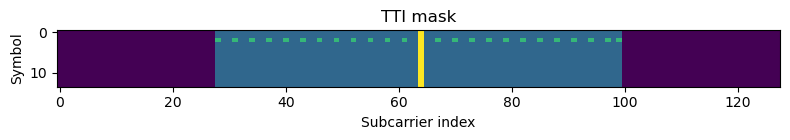

In [2]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=True)
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power)

In [3]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power)
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=False)
    TD_TTI_IQ = FFT(Modulated_TTI)
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP)
    return pdsch_bits, TX_Samples

In [4]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self):
        self.pdsch_iq = []
        self.pilot_iq = []
        self.labels = []
        
    def __len__(self):
        return len(self.pdsch_iq)
    
    def __getitem__(self, index):
        x1 = self.pdsch_iq[index]
        x2 = self.pilot_iq[index]
        y = self.labels[index]
        return x1, x2, y
    
    def add_item(self, new_pdsch_iq, new_pilot_iq, new_label):
        self.pdsch_iq.append(new_pdsch_iq)
        self.pilot_iq.append(new_pilot_iq)
        self.labels.append(new_label)
        
dataset = CustomDataset()

In [5]:
number_of_training_items = 1000

ch_SINR_min = 30 # channel emulation min SINR
ch_SINR_max = 40 # channel emulation max SINR

for i in range(number_of_training_items):
    if i % 1000 == 0:
        print(i)
    ch_SINR = int(random.uniform(ch_SINR_min, ch_SINR_max)) # SINR generation
    pdsch_bits, TX_Samples = create_OFDM_data() # data stream
    RX_Samples = generate_cdl_c_impulse_response(tx_signal = TX_Samples, num_samples=100, sampling_rate=SampleRate, SINR=ch_SINR, repeats = 2, random_start=False) # convolve channel with tx signal
    RX_NO_CP = CP_removal(RX_Samples, 0, S, FFT_size, CP, plotsig=False)
    RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP))
    OFDM_demod = DFT(RX_NO_CP, plotDFT=False)
    pilot_symbols = get_pilot_symbols_raw(TTI_mask_RE, OFDM_demod)
    pdsch_symbols = get_payload_symbols_raw(TTI_mask_RE, OFDM_demod)
    dataset.add_item(pdsch_symbols, pilot_symbols, pdsch_bits)
    
torch.save(dataset, 'ofdm_dataset.pth')
    

0


In [6]:
# print the last item in the dataset
print(dataset.pdsch_iq[-1].shape, dataset.pilot_iq[-1].shape, dataset.labels[-1].shape) 

torch.Size([970]) torch.Size([24]) torch.Size([970, 4])
